## 문제정의
* Given
  * white-box DNN model
  * 공격하고자 하는 이미지 셋 (총 500 장)
  * 모델 구조는 아래 코드 참고
  * 사전 학습 된 모델 가중치와 이미지셋은 [링크](https://1drv.ms/u/s!AuS4E8bOdN2Blpd1jw9ilzNhT0dI3Q?e=yKGlel)에서 다운로드 (2020년 6월 20일에 만료)
* Goal
  * pretrained model (의 가중치는 변경하지 않음) 을 속일 수 있는 adversarial examples 10 장 생성

In [2]:
# 필요한 패키지 불러오기
import os
from os import path
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras import (models, layers, losses,)
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
print('tf',tf.__version__)

tf 2.1.0


## 데이터 불러오기
* 데이터는 앞서 다운로드 링크 제공

In [4]:
X_test = np.load('../data/X_test.npy')
y_test = np.load('../data/y_test.npy')

print(X_test.shape, y_test.shape)

(500, 160, 160, 3) (500,)


## 사전학습 된 모델 불러오기
* 모델 구조는 아래 Model 클래스와 같음
* 사전학습 된 가중치는 앞서 다운로드 링크 제공

In [5]:
class Model(models.Model):
    def __init__(self,base_model):
        super(Model,self).__init__()
        self.base_model = base_model
        self.top_layer = models.Sequential([
            layers.Dense(10),
            layers.Activation(tf.nn.softmax),
        ])
        
    def call(self,inputs,training=False):
        x = self.base_model(inputs, training=training)
        x = layers.Flatten()(x)
        outputs = self.top_layer(x, training=training)
        return outputs

In [6]:
# weight loading
with open('../model/model_20200507_9_1.00_0.0088','rb') as w:
    weights = pickle.load(w)

base_model = tf.keras.applications.MobileNetV2(input_shape=[160, 160, 3], include_top=False,weights='imagenet')

# white-box model
model = Model(base_model)
model.build((None,160,160,3))
model.set_weights(weights)

## 예시: FGSM을 이용한 공격 [\[paper\]](https://arxiv.org/abs/1412.6572)
* white-box attack

In [7]:
# 공격하고자 하는 이미지 하나 선정
idx = 304
image = X_test[idx]
label = y_test[idx]

In [8]:
idx

304

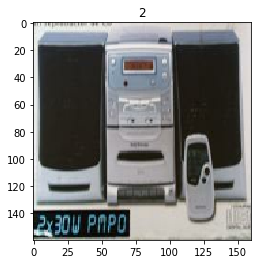

In [9]:
plt.imshow(image)
plt.title(str(label))
plt.show()

### FGSM 구현
**perturbation 생성**
$$
adv_x = x - \epsilon \cdot sign(\nabla_x J(\theta, x, y))
$$
이 때,
* $adv_x$ : adversarial image
* $x$ : original input image
* $y$ : original input label
* $\epsilon$ : perturbation 변화 한계치
* $\theta$ : model parameters
* $J$ : loss

In [10]:
loss_object = losses.SparseCategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    """
    args:
        원본 이미지, target_label
    return:
        grad 방향
    """
    input_image = tf.convert_to_tensor([input_image])
    
    with tf.GradientTape() as t:
        t.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
        
    grad = t.gradient(loss, input_image)
    signed_grad = tf.sign(grad)
    
    return signed_grad

In [11]:
# perturbation 생성
perturbation = create_adversarial_pattern(image, label)[0]

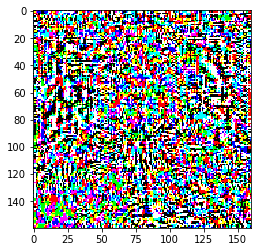

In [12]:
plt.imshow(perturbation)
plt.show()

In [13]:
def display_image(original_image, adv):
    original_image = np.expand_dims(original_image, axis=0)
    adv = np.expand_dims(adv, axis=0)
    
    original_label = model(original_image).numpy()[0]
    adv_label = model(adv).numpy()[0]
    
    title = f'original label = {np.argmax(original_label)}, confidence = {original_label[np.argmax(original_label)]*100:.2f}% -> {adv_label[np.argmax(original_label)]*100:.2f}%,   adv label = {np.argmax(adv_label)}'
    
    plt.imshow(np.squeeze(adv))
    plt.title(title)
    plt.show()

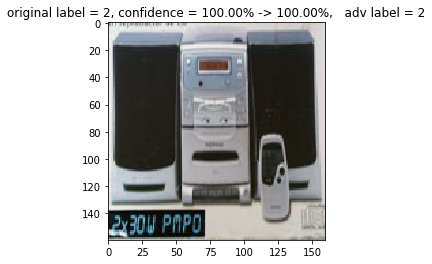

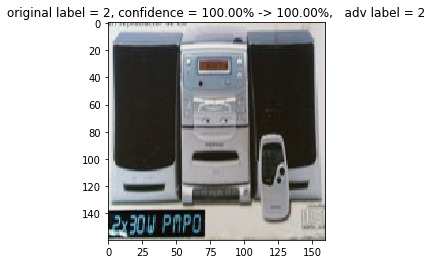

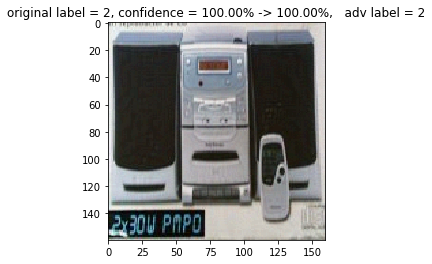

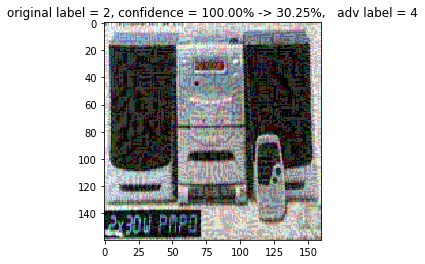

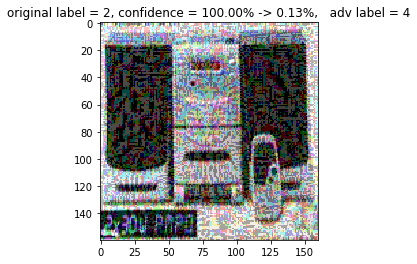

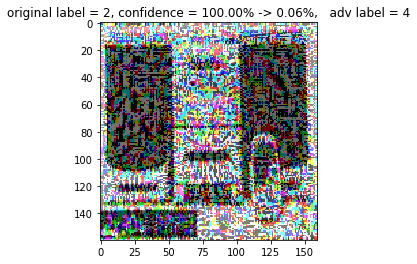

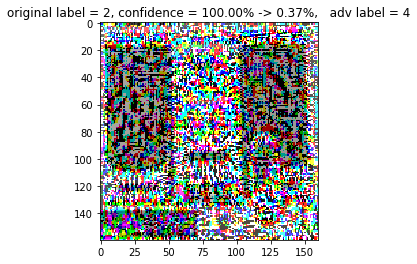

In [14]:
# 원본 이미지에 perturbation 공격
epsilon = [0, 1e-3, 1e-2, 1e-1, .15, .3, .5]

for i, eps in enumerate(epsilon):
    adv_x = image - eps * perturbation
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    display_image(image, adv_x)